# **Case Datarisk - Score de Crédito**

## **Importa as bibliotecas e Carrega os Dados**

In [519]:
from utils.load_df import load_df
from utils.convert_to_datetime import convert_to_datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

import requests
from pathlib import Path

from sklearn.metrics import roc_curve

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 

In [520]:
# Carregar os DataFrames
df_train = load_df("./data/train.parquet")
X_train = df_train.drop('inadimplente', axis=1)
y_train = df_train['inadimplente']

df_test = load_df("./data/test.parquet")
X_test = df_test.drop('inadimplente', axis=1)
y_test = df_test['inadimplente']

df_val= load_df("./data/validation.parquet")
X_val = df_val.drop('inadimplente', axis=1)
y_val = df_val['inadimplente']

## **Modelagem**

### **Funções**


In [521]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc

def train_and_evaluate_model(model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test):

  # Treinar o modelo
  model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc')

  # Fazer previsões no conjunto de teste
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  y_pred = model.predict(X_test)

  return y_pred_proba, y_pred


In [522]:
def plotProbHistograms(y_pred_proba, y_test, ax):
  """
  Gera e exibe histogramas das probabilidades previstas para múltiplos modelos
  em um eixo matplotlib específico.

  Args:
      y_pred_proba (np.array): Probabilidades previstas para a classe positiva (1).
      y_test (pd.Series): Valores verdadeiros da target.
      ax (matplotlib.axes.Axes): O eixo onde os histogramas serão desenhados.
  """

  df_plot = pd.DataFrame({
      'Probabilidade': y_pred_proba,
      'Classe': y_test.astype(int)
  })

  # Para cada classe, faz um subplot no eixo fornecido
  sns.histplot(
      data=df_plot[df_plot['Classe'] == 0],
      x='Probabilidade',
      bins=30,
      stat='density',
      color='blue',
      label='Classe 0 (Não Inadimplente)',
      kde=True, # Adicionar Kernel Density Estimate para suavizar o histograma
      ax=ax # Especifica o eixo para plotar
  )
  sns.histplot(
      data=df_plot[df_plot['Classe'] == 1],
      x='Probabilidade',
      bins=30,
      stat='density',
      color='red',
      label='Classe 1 (Inadimplente)',
      kde=True, # Adicionar Kernel Density Estimate para suavizar o histograma
      ax=ax # Especifica o eixo para plotar
  )

  ax.set_title('Distribuição das Probabilidades Previstas por Classe', fontsize=14)
  ax.set_xlabel('Probabilidade Prevista')
  ax.set_ylabel('Densidade')
  ax.legend()
  ax.grid(True)

In [523]:
def plot_ks_curve(y_true, y_probas_positive, title='Curva KS', ax=None):
    """
    Plota a curva KS (Kolmogorov-Smirnov) para um modelo de classificação binária.
    A visualização do KS foi melhorada para ser visível mesmo com valores muito baixos.
    """
    # 1. Cria um DataFrame com os dados (sem alterações)
    df = pd.DataFrame({
        'y_true': y_true,
        'y_proba': y_probas_positive
    })
    df = df.sort_values(by='y_proba').reset_index(drop=True)

    # 2. Calcula as distribuições acumuladas (sem alterações)
    total_positives = df['y_true'].sum()
    total_negatives = len(df) - total_positives
    
    # Adicionado um pequeno valor (epsilon) para evitar divisão por zero se uma classe não estiver presente
    if total_positives == 0 or total_negatives == 0:
        print("Aviso: Dados de entrada contêm apenas uma classe. A curva KS não pode ser calculada.")
        return 0, 0, ax
        
    df['cdf_positive'] = df['y_true'].cumsum() / total_positives
    df['cdf_negative'] = (1 - df['y_true']).cumsum() / total_negatives

    # 3. Calcula o KS (sem alterações)
    df['ks'] = abs(df['cdf_positive'] - df['cdf_negative'])
    ks_statistic = df['ks'].max()
    
    best_threshold_row = df.loc[df['ks'].idxmax()]
    best_threshold = best_threshold_row['y_proba']
    y_positive_at_ks = best_threshold_row['cdf_positive']
    y_negative_at_ks = best_threshold_row['cdf_negative']

    # 4. Configuração do plot (sem alterações)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # 5. Plot das curvas e do KS (ESTA PARTE FOI ALTERADA)
    ax.plot(df['y_proba'], df['cdf_positive'], label='CDF Positivos (Classe 1)')
    ax.plot(df['y_proba'], df['cdf_negative'], label='CDF Negativos (Classe 0)')
    
    ax.plot([best_threshold, best_threshold], [y_negative_at_ks, y_positive_at_ks],
            linestyle='--', color='red', label=f'KS = {ks_statistic:.4f}')

    # Adiciona uma anotação com uma seta para mostrar a distância exata
    ax.annotate(
        f'KS = {ks_statistic:.4f}',
        xy=(best_threshold, y_negative_at_ks),
        xytext=(best_threshold + 0.1, y_negative_at_ks + 0.2), # Posição do texto
        arrowprops=dict(facecolor='black', shrink=0.05),
        horizontalalignment='center',
        verticalalignment='bottom'
    )
    
    # 6. Estilização do gráfico (sem alterações)
    ax.set_title(title)
    ax.set_xlabel('Probabilidade (Score)')
    ax.set_ylabel('Percentual Acumulado')
    ax.legend()
    ax.grid(True)
    
    return ks_statistic, best_threshold

In [524]:
def evaluate_metrics(y_test, y_pred_proba):
    """
    Calcula as principais métricas de avaliação para um modelo de classificação binária.
    Retorna um DataFrame com os valores.
    """

    # AUC ROC
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Curva PR e PR-AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc_score = auc(recall_curve, precision_curve)

    # Estatística KS (corrigida)
    df_ks = pd.DataFrame({'proba': y_pred_proba, 'target': y_test})
    df_ks = df_ks.sort_values('proba', ascending=False).reset_index(drop=True)

    df_ks['cum_pos'] = (df_ks['target'] == 1).cumsum() / (df_ks['target'] == 1).sum()
    df_ks['cum_neg'] = (df_ks['target'] == 0).cumsum() / (df_ks['target'] == 0).sum()
    df_ks['ks'] = df_ks['cum_pos'] - df_ks['cum_neg']

    ks_score = df_ks['ks'].max()
    ks_index = df_ks['ks'].idxmax()
    ks_threshold = df_ks['proba'].iloc[ks_index]

    # Precision e Recall no threshold KS
    precision = precision_score(y_test, y_pred_proba >= ks_threshold)
    recall = recall_score(y_test, y_pred_proba >= ks_threshold)

    metrics = pd.DataFrame({
        'Métrica': [
            'AUC (ROC)',
            'PR-AUC',
            'KS Statistic',
            'KS Threshold',
            'Precision (no KS)',
            'Recall (no KS)'
        ],
        'Valor': [
            round(auc_score, 4),
            round(pr_auc_score, 4),
            round(ks_score, 4),
            round(ks_threshold, 4),
            round(precision, 4),
            round(recall, 4)
        ]
    })

    return metrics


def plot_report(y_test, y_pred_proba, title='Relatório de Performance'):
    """
    Gera um dashboard 2x2 com as principais métricas de avaliação para um modelo de classificação binária.
    Inclui AUC, PR-AUC, KS e distribuição de probabilidades.
    """

    # 1. CÁLCULO DAS MÉTRICAS
    metrics = evaluate_metrics(y_test, y_pred_proba)
    display(metrics)

    auc_score = metrics.loc[metrics['Métrica'] == 'AUC (ROC)', 'Valor'].values[0]
    pr_auc_score = metrics.loc[metrics['Métrica'] == 'PR-AUC', 'Valor'].values[0]

    # Curva Precision-Recall
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # 2. DASHBOARD 2x2
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    fig.suptitle(title, fontsize=20)

    # --- Gráfico 2: Curva ROC ---
    ax1 = axes[0, 0]
    ax1.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='darkorange')
    ax1.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax1.set_title('Curva ROC', fontsize=14)
    ax1.set_xlabel('FPR (Taxa de Falsos Positivos)')
    ax1.set_ylabel('TPR (Taxa de Verdadeiros Positivos)')
    ax1.legend()
    ax1.grid(True)

    # --- Gráfico 3: Curva KS ---
    from matplotlib.ticker import PercentFormatter
    ax2 = axes[0, 1]
    ks_value, best_threshold = plot_ks_curve(y_test, y_pred_proba, ax=ax2)
    ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax2.set_title(f'Curva KS (KS={ks_value:.2%})', fontsize=14)

    # --- Gráfico 4: Distribuição das Probabilidades ---
    ax3 = axes[1, 0]
    plotProbHistograms(y_pred_proba, y_test, ax=ax3)
    ax3.set_title('Distribuição das Probabilidades', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [525]:
def plot_feature_importance(feature_importances):

  # Plotar a importância das features
  plt.figure(figsize=(8, 6))
  sns.barplot(x='Importance', y='Feature', data=feature_importances)
  plt.title('Importância das Features')
  plt.xlabel('Importância')
  plt.ylabel('Feature')
  plt.tight_layout()
  plt.show()

In [526]:
params = {
    'class_weight': 'balanced',
    'seed': 42
}

# Criar o modelo LightGBM
model = lgb.LGBMClassifier(**params)
y_pred_proba, y_pred = train_and_evaluate_model(model)

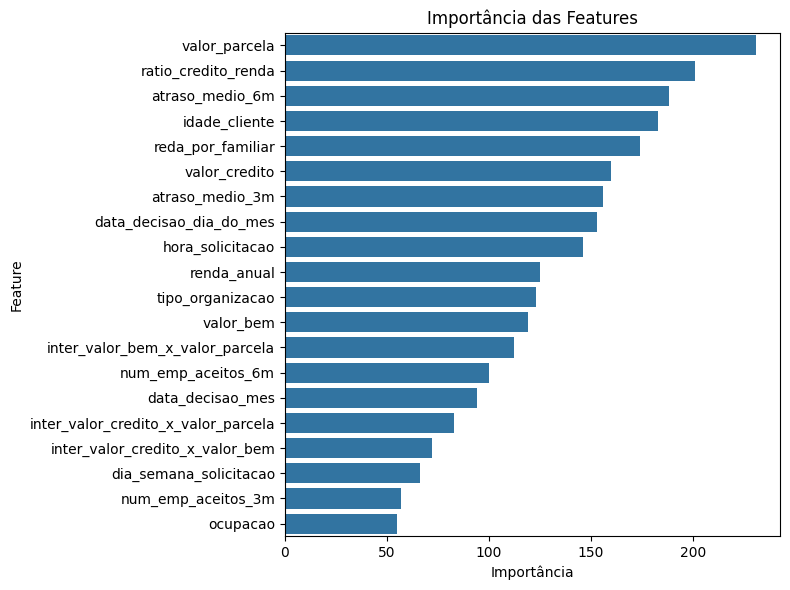

In [527]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plot_feature_importance(feature_importances)

,Métrica,Valor
0,AUC (ROC),0.6032
1,PR-AUC,0.0064
2,KS Statistic,0.2111
3,KS Threshold,0.1654
4,Precision (no KS),0.0071
5,Recall (no KS),0.5000


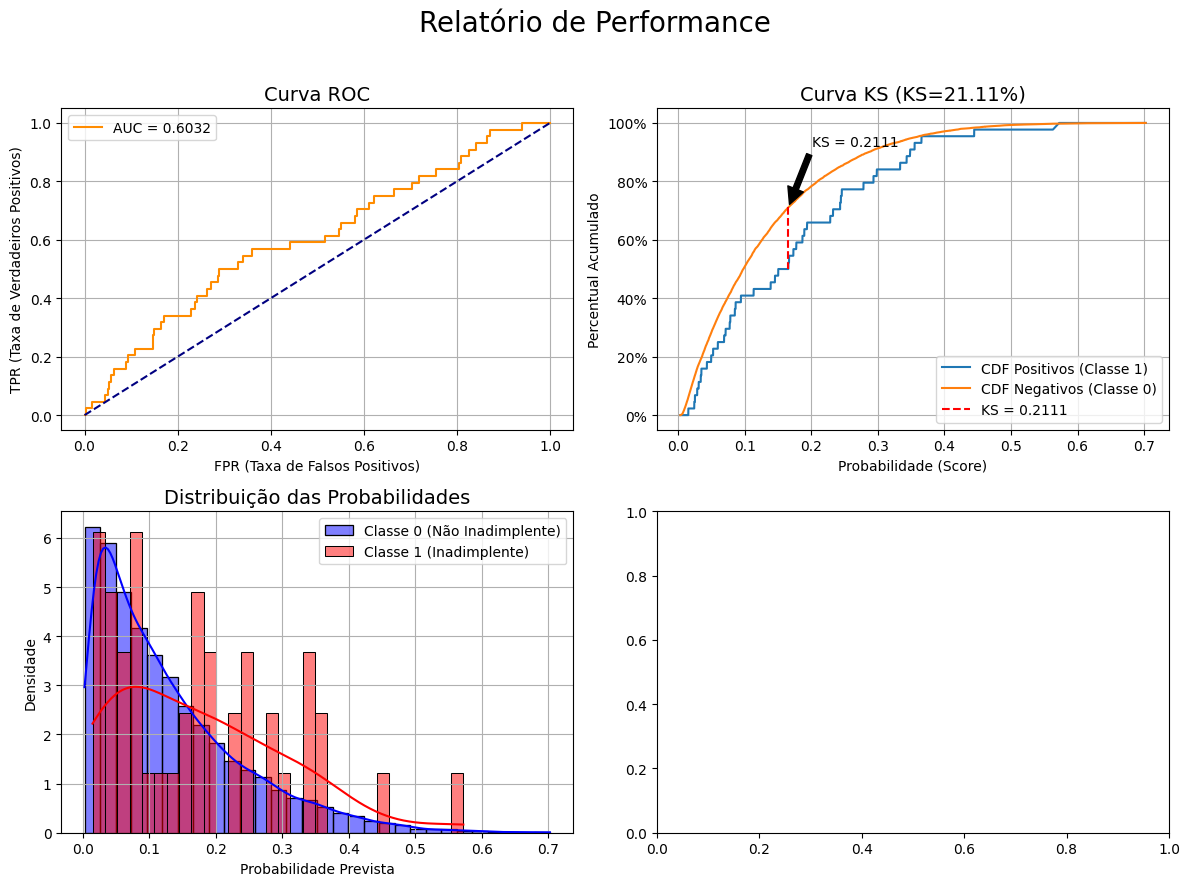

In [528]:
plot_report(y_test, y_pred_proba)

## Threashold Manual de Feature Importance

In [529]:
features_to_keep = feature_importances[feature_importances['Importance'] >= 150]['Feature'].tolist()

X_train_biggest_fi = X_train[features_to_keep]
X_test_biggest_fi = X_test[features_to_keep]
X_val_biggest_fi = X_val[features_to_keep]

print(f"Número de features após descarte: {len(features_to_keep)}")
print("Features restantes:")
print(features_to_keep)

Número de features após descarte: 8
Features restantes:
['valor_parcela', 'ratio_credito_renda', 'atraso_medio_6m', 'idade_cliente', 'reda_por_familiar', 'valor_credito', 'atraso_medio_3m', 'data_decisao_dia_do_mes']


In [530]:
params = {
    'class_weight': 'balanced',
    'seed': 42
}

# Criar o modelo LightGBM
model = lgb.LGBMClassifier(**params)
y_pred_proba, y_pred = train_and_evaluate_model(model, X_train=X_train_biggest_fi, y_train=y_train, X_test=X_test_biggest_fi, X_val=X_val_biggest_fi)

In [531]:
na_cols = X_train.isna().sum()
na_cols = na_cols[na_cols > 0]
if not na_cols.empty:
    display(na_cols)
else:
    print('Não há valores NA em X_train')

y_na = y_train.isna().sum()
if y_na > 0:
    display(y_na)
else:
    print('Não há valores NA em y_train')

Não há valores NA em X_train
Não há valores NA em y_train


,Métrica,Valor
0,AUC (ROC),0.6130
1,PR-AUC,0.0055
2,KS Statistic,0.1992
3,KS Threshold,0.2188
4,Precision (no KS),0.0059
5,Recall (no KS),0.6591


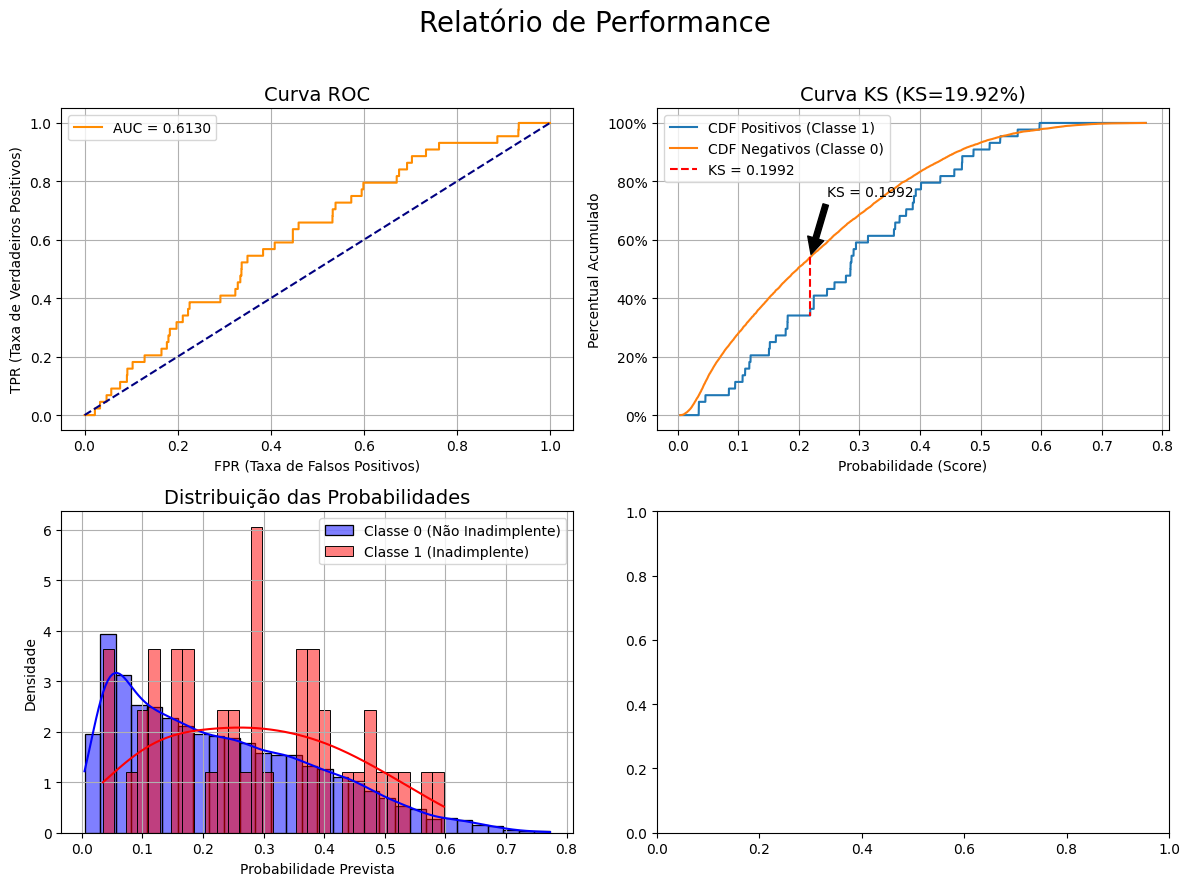

In [532]:
plot_report(y_test, y_pred_proba)

## Seleção de Features com Boruta

In [533]:
def select_features_boruta(X_train, y_train):
    # Random Forest Classifier
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

    # Boruta
    feat_selector = BorutaPy(
        estimator=rf,
        n_estimators='auto',
        verbose=2,
        max_iter=20,
        random_state=42
    )

    feat_selector.fit(X_train.values, y_train.squeeze().values)

    # Selecionar as features aprovadas pelo Boruta
    cols_selected_boruta = X_train.columns[feat_selector.support_].to_list()
    print(f'Número de features selecionadas pelo Boruta: {len(cols_selected_boruta)}')

    return cols_selected_boruta

cols_selected_boruta = select_features_boruta(X_train, y_train)

Iteration: 	1 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	2 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	3 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	4 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	5 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	6 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	7 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	8 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	9 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	10 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	11 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	12 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	13 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	14 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	15 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	16 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	17 / 

In [534]:
print("Features selecionadas pelo Boruta:", cols_selected_boruta)

Features selecionadas pelo Boruta: ['valor_credito', 'valor_bem', 'valor_parcela', 'ratio_credito_renda', 'inter_valor_credito_x_valor_bem']


In [535]:
X_train_boruta = X_train[cols_selected_boruta]
X_test_boruta = X_test[cols_selected_boruta]
X_val_boruta = X_val[cols_selected_boruta]

In [536]:
params = {
    'class_weight': 'balanced',
    'seed': 42
}

# Criar o modelo LightGBM
model = lgb.LGBMClassifier(**params)
y_pred_proba, y_pred = train_and_evaluate_model(model, X_train=X_train_boruta, X_test=X_test_boruta, X_val=X_val_boruta)

,Métrica,Valor
0,AUC (ROC),0.5978
1,PR-AUC,0.0058
2,KS Statistic,0.1980
3,KS Threshold,0.4050
4,Precision (no KS),0.0070
5,Recall (no KS),0.4773


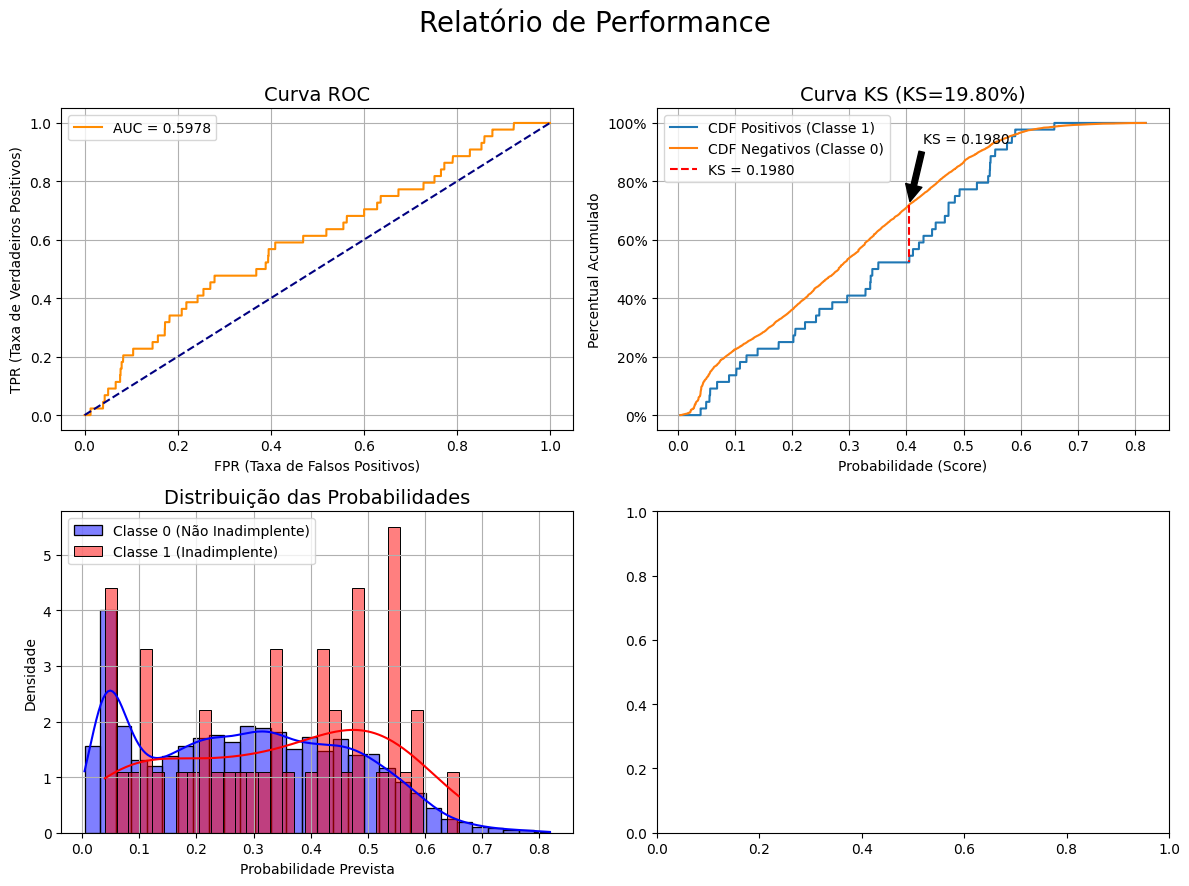

In [537]:
plot_report(y_test, y_pred_proba)

## **SMOTE**

In [538]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [539]:
counter = Counter(y_train)
print(counter)

Counter({0.0: 48417, 1.0: 1313})


In [540]:
oversample = SMOTE(sampling_strategy=0.1)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [541]:
counter = Counter(y_train_smote)
print(counter)

Counter({0.0: 48417, 1.0: 4841})


In [542]:
model = lgb.LGBMClassifier()
y_pred_proba, y_pred = train_and_evaluate_model(model, X_train=X_train_smote, y_train=y_train_smote)

,Métrica,Valor
0,AUC (ROC),0.5984
1,PR-AUC,0.0059
2,KS Statistic,0.2204
3,KS Threshold,0.0144
4,Precision (no KS),0.0074
5,Recall (no KS),0.5000


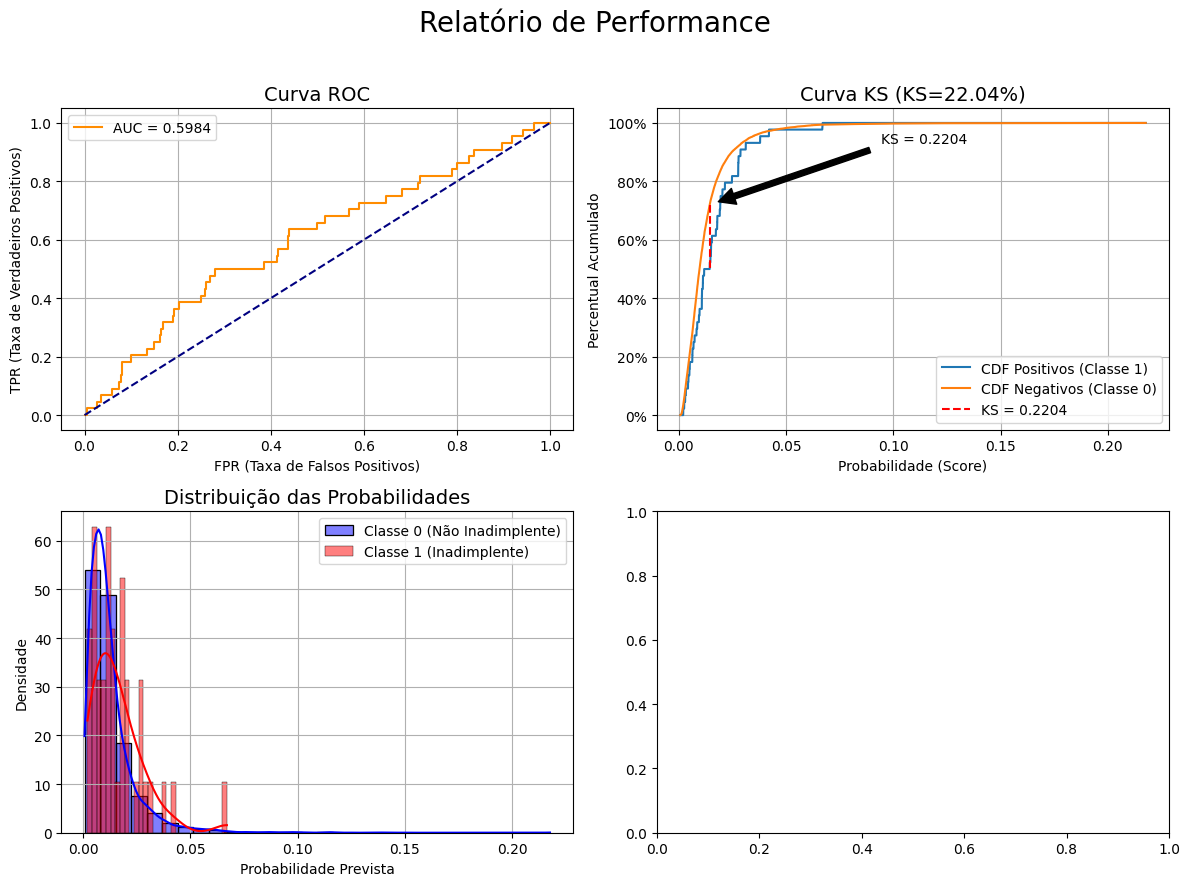

In [543]:
plot_report(y_test, y_pred_proba)

## Otimiza Hiperparâmetros com Optuna

In [546]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cat

In [547]:
search_spaces = {
    "lightgbm": {
        "n_estimators": lambda trial: trial.suggest_int("n_estimators", 200, 2000),
        "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "num_leaves": lambda trial: trial.suggest_int("num_leaves", 20, 500),
        "max_depth": lambda trial: trial.suggest_int("max_depth", 3, 12),
        "lambda_l1": lambda trial: trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": lambda trial: trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "feature_fraction": lambda trial: trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": lambda trial: trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": lambda trial: trial.suggest_int("bagging_freq", 1, 7),
    },
    "xgboost": {
        "n_estimators": lambda trial: trial.suggest_int("n_estimators", 200, 2000),
        "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "max_depth": lambda trial: trial.suggest_int("max_depth", 3, 12),
        "subsample": lambda trial: trial.suggest_float("subsample", 0.6, 1.0), # Equivalente a bagging_fraction
        "colsample_bytree": lambda trial: trial.suggest_float("colsample_bytree", 0.6, 1.0), # Equivalente a feature_fraction
        "reg_alpha": lambda trial: trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True), # L1
        "reg_lambda": lambda trial: trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True), # L2
        "gamma": lambda trial: trial.suggest_float("gamma", 1e-8, 1.0, log=True),
    },
    "catboost": {
        "iterations": lambda trial: trial.suggest_int("iterations", 200, 2000), # Equivalente a n_estimators
        "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "depth": lambda trial: trial.suggest_int("depth", 3, 12), # Equivalente a max_depth
        "l2_leaf_reg": lambda trial: trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True), # L2
        "subsample": lambda trial: trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bylevel": lambda trial: trial.suggest_float("colsample_bylevel", 0.6, 1.0),
        "random_strength": lambda trial: trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
    }
}

In [548]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score


def objective(trial, model_name, X_train, y_train, X_val, y_val):
    """
    Função genérica que o Optuna irá otimizar.
    Ela recebe o nome do modelo, busca seus parâmetros e retorna o score (AUC).
    """
    # 1. Seleciona o espaço de busca para o modelo atual
    model_search_space = search_spaces[model_name]

    # 2. Cria o dicionário de parâmetros usando as sugestões do trial
    params = {name: func(trial) for name, func in model_search_space.items()}

    # 3. Instancia o modelo correto com base no nome
    if model_name == "lightgbm":
        model = lgb.LGBMClassifier(objective='binary', metric='auc', verbosity=-1, random_state=42, **params)
    elif model_name == "xgboost":
        model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42, use_label_encoder=False, **params)
    elif model_name == "catboost":
        model = cat.CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_seed=42, verbose=0, **params)

    # 4. Treina e avalia o modelo
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    
    return auc

In [550]:
import pickle
from tqdm.auto import tqdm
import optuna
import optuna.study.study as _study_module

# Monkeypatch Study.optimize to show a tqdm progress bar for n_trials (falls back gracefully if n_trials is None)
_orig_optimize = _study_module.Study.optimize

def _optimize_with_tqdm(self, func, n_trials=None, timeout=None, n_jobs=1, catch=(Exception,), callbacks=None, gc_after_trial=True, *args, **kwargs):
    total = n_trials if n_trials is not None else None
    pbar = tqdm(total=total, desc=f"Optuna: {self.study_name}", unit="trial")
    def _update(study, trial):
        pbar.update(1)
    callbacks = list(callbacks or []) + [_update]
    try:
        return _orig_optimize(self, func, n_trials=n_trials, timeout=timeout, n_jobs=n_jobs, catch=catch, callbacks=callbacks, gc_after_trial=gc_after_trial, *args, **kwargs)
    finally:
        pbar.close()

_study_module.Study.optimize = _optimize_with_tqdm

best_results = {}

for model_name in search_spaces.keys():
    print(f"\n--- Otimizando {model_name.upper()} ---")

    # Cria um estudo para o modelo atual
    study = optuna.create_study(direction='maximize', study_name=f"{model_name}_optimization")

    # Otimiza a função objective, passando os argumentos extras através de um lambda
    study.optimize(
        lambda trial: objective(trial, model_name, X_train, y_train, X_val, y_val),
        n_trials=40  # Defina o número de tentativas que desejar
    )

    # Guarda os melhores resultados
    best_results[model_name] = {
        "best_value": study.best_value,
        "best_params": study.best_trial.params
    }

    print(f"Melhor AUC para {model_name}: {study.best_value:.4f}")
    print("Melhores parâmetros:")
    for key, value in study.best_trial.params.items():
        print(f"  {key}: {value}")

    # Instancia o modelo apropriado para o tipo otimizado
    best_params = study.best_trial.params
    if model_name == "lightgbm":
        model = lgb.LGBMClassifier(objective='binary', metric='auc', verbosity=-1, random_state=42, **best_params)
    elif model_name == "xgboost":
        model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42, use_label_encoder=False, **best_params)
    elif model_name == "catboost":
        model = cat.CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_seed=42, verbose=0, **best_params)

    # Treina, avalia e plota relatório
    y_pred_proba, y_pred = train_and_evaluate_model(model)
    plot_report(y_test, y_pred_proba)

    # Salva o modelo treinado
    model_filename = f"{model_name}_best_optuna_model.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)

    print(f"Modelo salvo em: {model_filename}")

[I 2025-10-21 00:00:06,195] A new study created in memory with name: lightgbm_optimization



--- Otimizando LIGHTGBM ---


Optuna: lightgbm_optimization:   8%|▊         | 3/40 [00:13<02:43,  4.41s/trial][W 2025-10-21 00:00:31,462] Trial 3 failed with parameters: {'n_estimators': 1892, 'learning_rate': 0.033784131626459435, 'num_leaves': 220, 'max_depth': 10, 'lambda_l1': 0.27448476147597517, 'lambda_l2': 3.634986496596995e-08, 'feature_fraction': 0.7002277087042986, 'bagging_fraction': 0.9211015508633561, 'bagging_freq': 5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/jvlm/repositories/case-ds/.venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/py/_hms0lwn3h70z03wxhxl24jm0000gp/T/ipykernel_31516/1372658098.py", line 32, in <lambda>
    lambda trial: objective(trial, model_name, X_train, y_train, X_val, y_val),
                  ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/py/_hms0lwn3h70z03wxhxl24jm0000gp/T/ipykernel_31516/1

KeyboardInterrupt: 

### Referências

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://medium.com/@balemar/t%C3%A9cnicas-para-dados-desbalanceados-smote-e-adasyn-f891f9c46c6e